In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import datetime

In [2]:
start = datetime.datetime(1967, 1, 7)
end = datetime.datetime(2024, 2, 24)
icnsa_df = web.DataReader('ICNSA', 'fred', start, end)

<Axes: xlabel='DATE'>

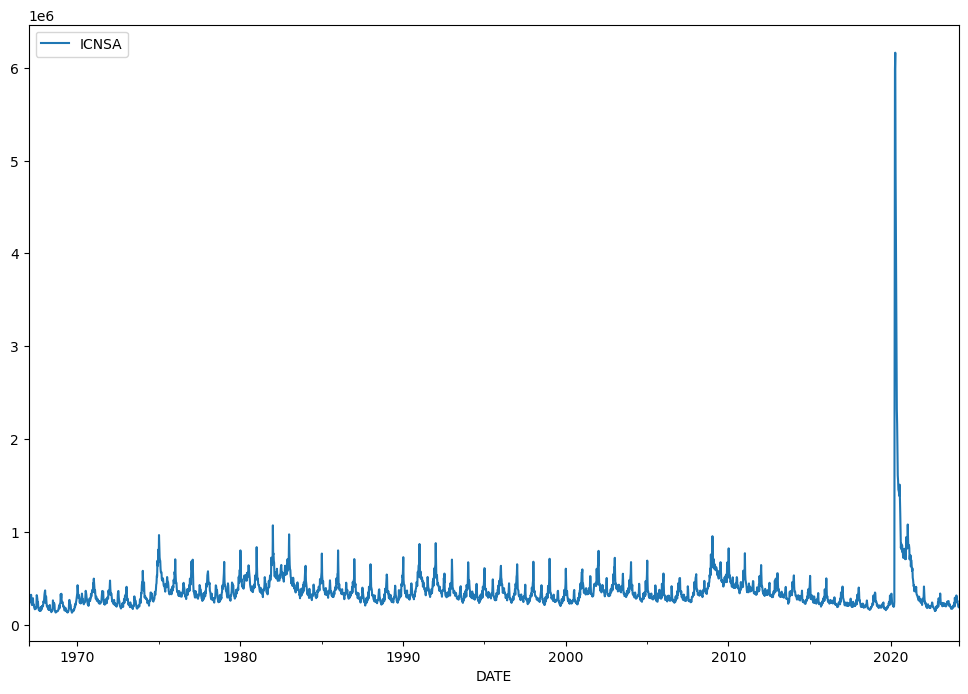

In [3]:
icnsa_df.plot(figsize=(12,8))

In [4]:
icnsa_df.index

DatetimeIndex(['1967-01-07', '1967-01-14', '1967-01-21', '1967-01-28',
               '1967-02-04', '1967-02-11', '1967-02-18', '1967-02-25',
               '1967-03-04', '1967-03-11',
               ...
               '2023-12-23', '2023-12-30', '2024-01-06', '2024-01-13',
               '2024-01-20', '2024-01-27', '2024-02-03', '2024-02-10',
               '2024-02-17', '2024-02-24'],
              dtype='datetime64[ns]', name='DATE', length=2982, freq=None)

In [5]:
unemprate_df = web.DataReader('UNRATE', 'fred', start, end)

<Axes: xlabel='DATE'>

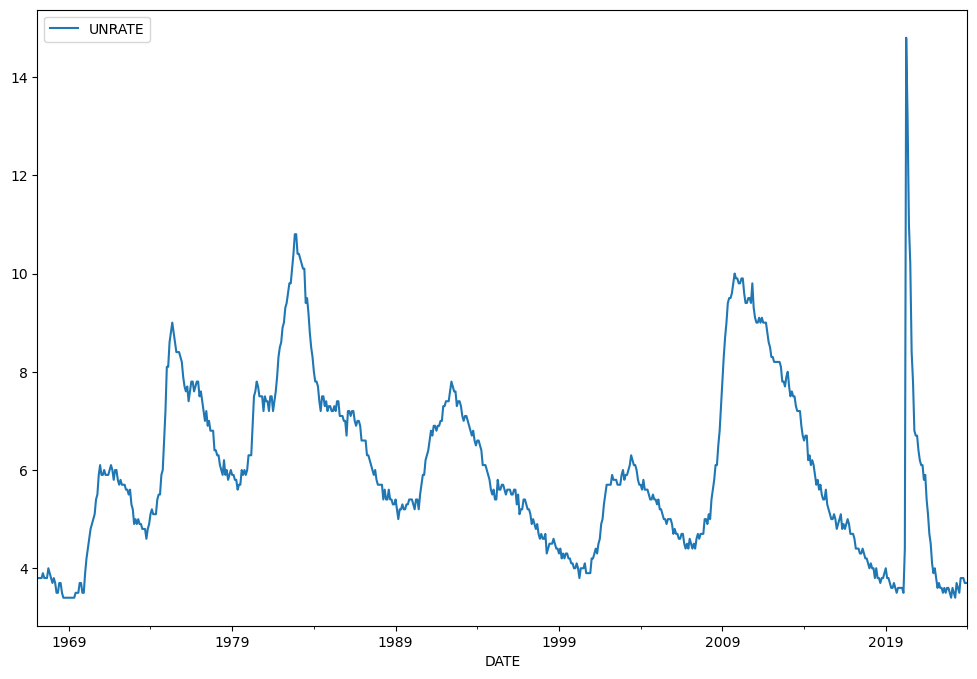

In [6]:
unemprate_df.plot(figsize=(12,8))

In [7]:
unemprate_df.index

DatetimeIndex(['1967-02-01', '1967-03-01', '1967-04-01', '1967-05-01',
               '1967-06-01', '1967-07-01', '1967-08-01', '1967-09-01',
               '1967-10-01', '1967-11-01',
               ...
               '2023-04-01', '2023-05-01', '2023-06-01', '2023-07-01',
               '2023-08-01', '2023-09-01', '2023-10-01', '2023-11-01',
               '2023-12-01', '2024-01-01'],
              dtype='datetime64[ns]', name='DATE', length=684, freq=None)

Checking for covid start and end dates

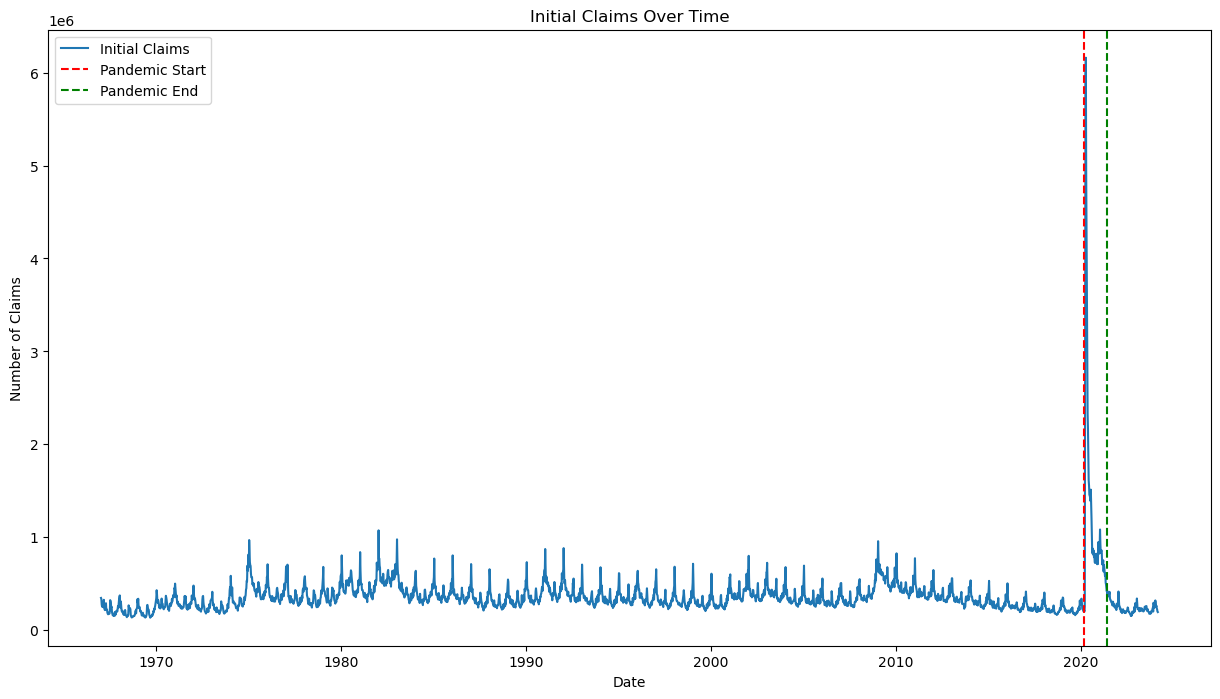

In [8]:
plt.figure(figsize=(15, 8))
plt.plot(icnsa_df.index, icnsa_df['ICNSA'], label='Initial Claims')

plt.axvline(x=pd.Timestamp('2020-03-01'), color='r', linestyle='--', label='Pandemic Start')
plt.axvline(x=pd.Timestamp('2021-06-01'), color='g', linestyle='--', label='Pandemic End')

plt.title('Initial Claims Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Claims')
plt.legend()
plt.show()


We found out when COVID-19 really started to affect things, which was around March 2020. That's when a lot of countries began to feel the impact, with things like lockdowns causing a lot of people to lose their jobs.

To figure out when COVID-19 started and ended, we looked for big increases in the number of people claiming unemployment benefits. This was a sign that the pandemic was hitting hard. Then, we looked for when those numbers started going down again, which could mean things were getting back to normal.

We think the COVID-19 impact period ended around June 2021. By then, many places were starting to recover, and the number of people losing their jobs was going down. But it's important to remember that the exact timing could be different depending on where you are.

In [9]:
print(start)

1967-01-07 00:00:00


/Users/simantinighosh/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
/Users/simantinighosh/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['robust']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.28123D+01    |proj g|=  8.80691D-03

At iterate    5    f=  1.28075D+01    |proj g|=  6.22268D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      7      8      1     0     0   7.707D-06   1.281D+01
  F =   12.807476628652307     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


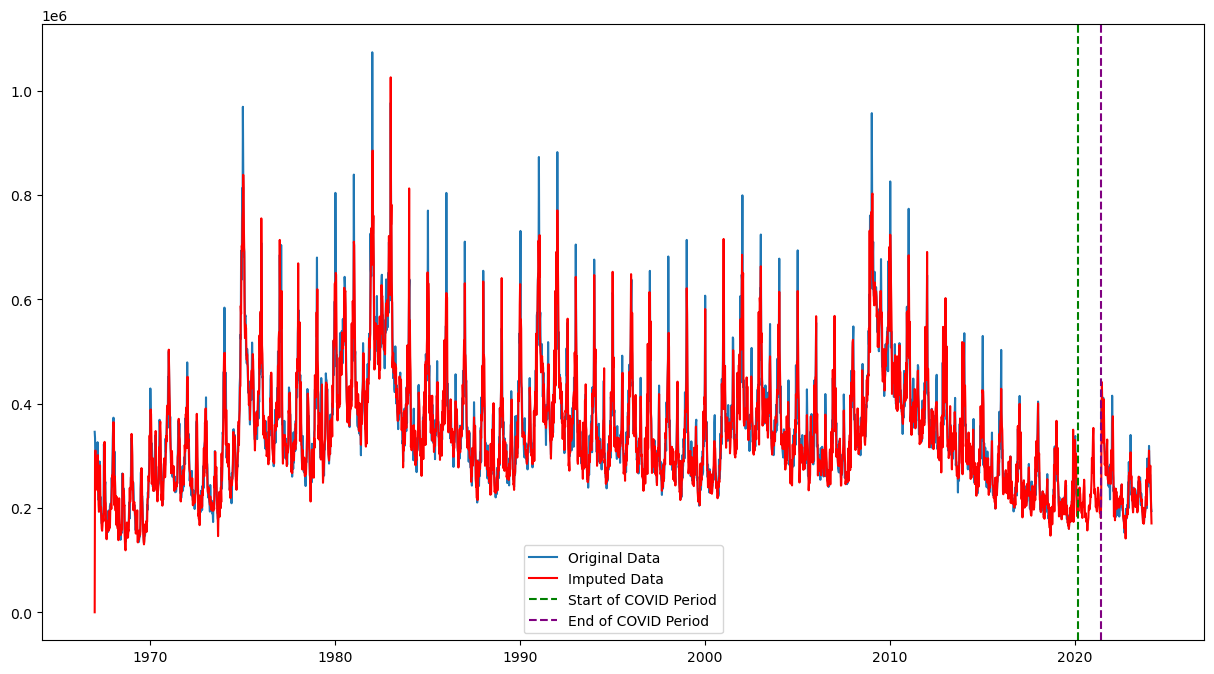

In [10]:
from statsmodels.tsa.statespace.structural import UnobservedComponents


start_index = datetime.datetime(2020, 3, 1)
end_index = datetime.datetime(2021, 6, 1)

icnsa_df.loc[start_index:end_index, 'ICNSA'] = np.nan

model = UnobservedComponents(icnsa_df['ICNSA'], 
                             level='llevel',  
                             seasonal=52,     
                             freq_seasonal=[{'period': 52, 'harmonics': 4}], 
                             autoregressive=1,
                             robust=True)  

results = model.fit()

# Impute the missing values using the predict method , it uses the Kalman Smoother internally for the imputation
icnsa_df['Imputed_ICNSA'] = results.predict()

# Plot the series with imputed values
plt.figure(figsize=(15, 8))
plt.plot(icnsa_df.index, icnsa_df['ICNSA'], label='Original Data')
plt.plot(icnsa_df.index, icnsa_df['Imputed_ICNSA'], label='Imputed Data', color='red')
plt.axvline(x=pd.Timestamp('2020-03-01'), color='green', linestyle='--', label='Start of COVID Period')
plt.axvline(x=pd.Timestamp('2021-06-01'), color='purple', linestyle='--', label='End of COVID Period')
plt.legend()
plt.show()

The Python documentation doesn't explicitly mention the KalmanSmoother. Instead, it recommends using the SARIMAX model from the statsmodels library for imputation tasks. The Kalman Filter, which is a crucial component of state-space models like SARIMAX for estimation and imputation, is inherently utilized by the library when fitting a SARIMAX model to impute missing values. During the execution of methods like `.fit()` and `.predict()`, the Smoother operates in the background as part of the state-space model's implementation in statsmodels. It works behind the scenes to provide estimates for missing or unobserved values based on the observed data.

/Users/simantinighosh/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)
/Users/simantinighosh/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['robust']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47806D+01    |proj g|=  6.71209D-04


 This problem is unconstrained.



At iterate    5    f=  1.47804D+01    |proj g|=  5.94881D-05

At iterate   10    f=  1.47797D+01    |proj g|=  1.15198D-03
  ys=-2.406E-01  -gs= 5.269E-01 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     13     24      1     1     0   4.683D-06   1.269D+01
  F =   12.692729505850833     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


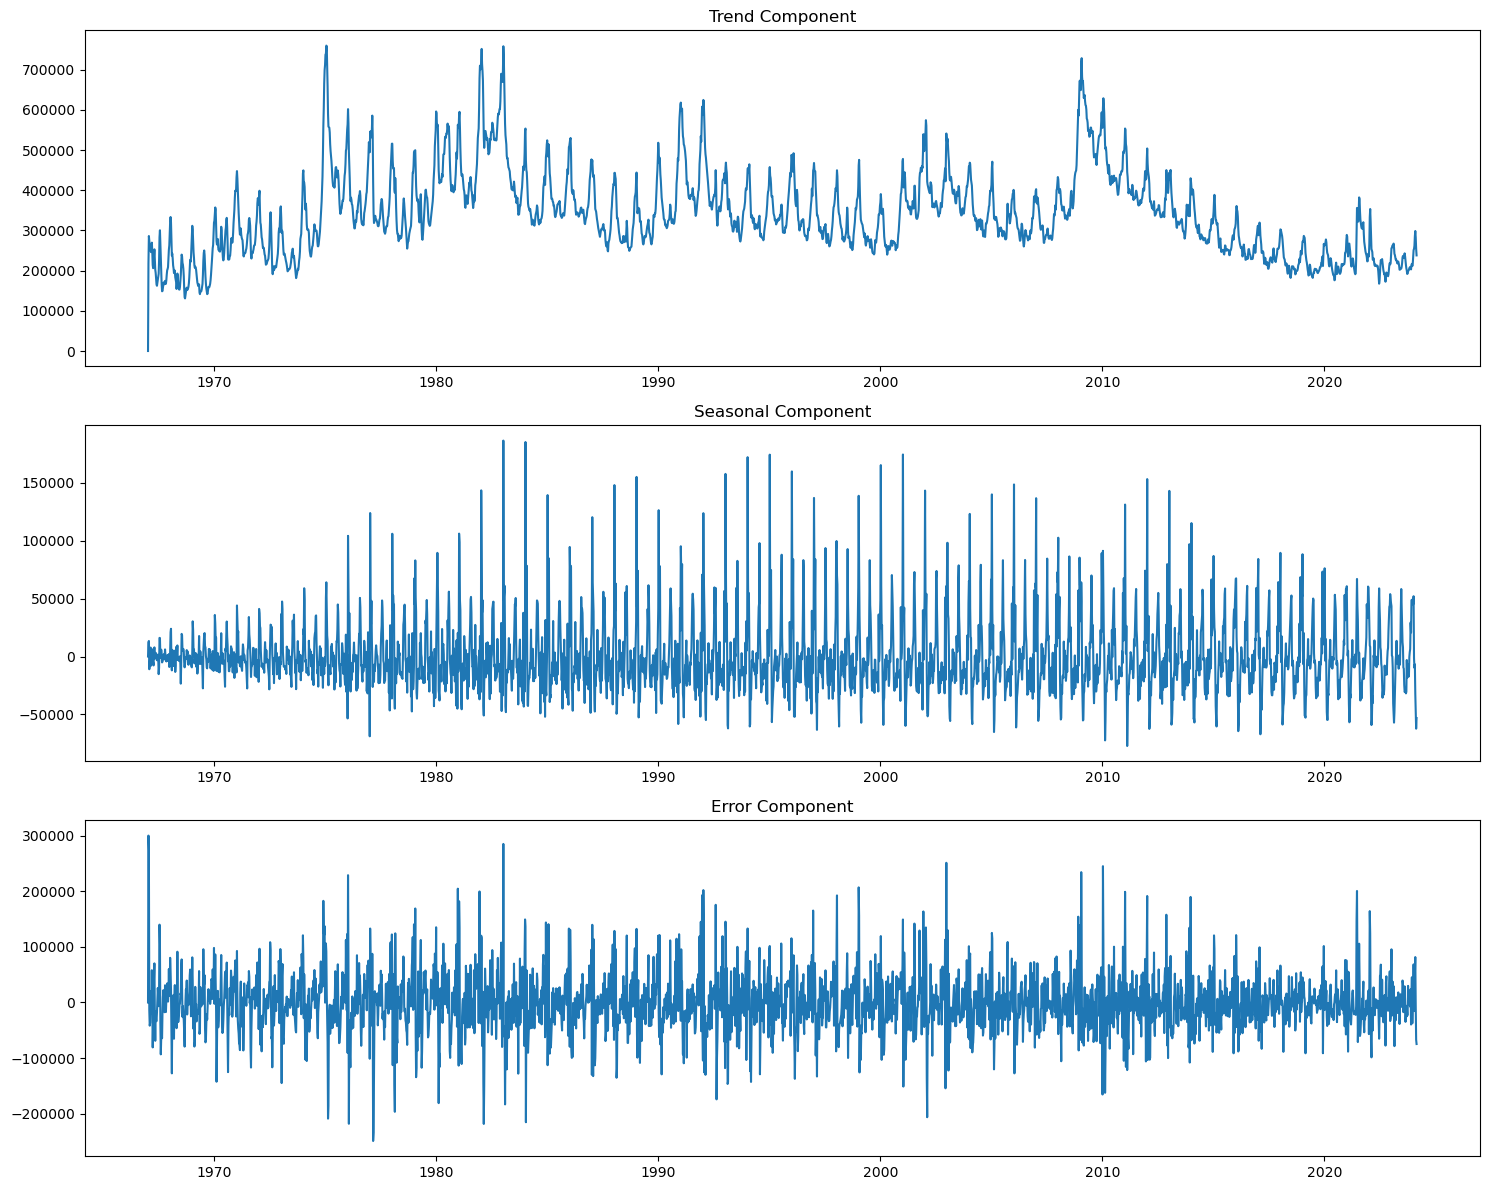

In [11]:
model_with_imputed = UnobservedComponents(
    icnsa_df['Imputed_ICNSA'], 
    level='llevel',
    seasonal=52,     
    freq_seasonal=[{'period': 52}], 
    autoregressive=1,
    robust=True      
)

imputed_results = model_with_imputed.fit()


# Plotting the components of the model
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 12))

# Level/Trend
axes[0].plot(icnsa_df.index, imputed_results.level.smoothed, label='Trend')
axes[0].set_title('Trend Component')

# Seasonal
axes[1].plot(icnsa_df.index, imputed_results.seasonal.smoothed, label='Seasonal')
axes[1].set_title('Seasonal Component')


# Error
axes[2].plot(icnsa_df.index, imputed_results.resid, label='Error')
axes[2].set_title('Error Component')

# Show the plot
plt.tight_layout()
plt.show()

The UnobservedComponents model is chosen for its ability to break down time series data into various components, each representing different underlying processes like trends or seasonal patterns.

This model offers flexibility in specifying the trend component, allowing for options such as local level or local linear trend, and can capture complex seasonal patterns effectively.

Additionally, it accounts for the autoregressive nature of time series data, which is evident from the lagged relationships within the data.

By setting the robust parameter to True, the model can provide more robust estimates that are less influenced by outliers. This can be particularly useful in time series data with anomalies or non-normal errors.

Specifically, the 'UnobservedComponents' model is configured with parameters such as "level='llevel'", "seasonal=52", and "autoregressive=1". This indicates that the ICNSA time series data is modeled with:

- A local level model to capture the underlying trend.
- A seasonal component with a yearly frequency (52 weeks considering the weekly data).
- An autoregressive component of order 1, reflecting the dependence of the series on its immediate past values.

The model is then fitted to the imputed_I_value series derived from the ICNSA data. These imputed values fill in the missing data points due to COVID-19, using estimates based on observed patterns within the data.

Level/Trend Component:

- The trend component displays discernible long-term trends in the ICNSA data, with identifiable peaks and troughs that may correspond to economic cycles.
- Variations in the trend's variance over time imply that the volatility of the series fluctuates. This variability suggests that different time periods may have differing levels of uncertainty, necessitating consideration within the model.

Seasonal Component:

- The seasonal component showcases regular oscillations, indicating a prominent seasonal pattern inherent in the ICNSA data.
- The consistency in the magnitude of seasonal effects over time suggests that the seasonal pattern remains relatively stable from year to year.

Error Component:

- The error component exhibits notable spikes, indicating the presence of unexplained fluctuations in the data.
- Potential causes for these spikes include outliers, structural changes such as those induced by the COVID-19 pandemic, or other factors not encompassed by the model.

In [12]:
df = icnsa_df.resample('M').mean()
df=df.iloc[1:len(df)-1]
df.head()

,ICNSA,Imputed_ICNSA
DATE,,
1967-02-28,261250.0,248886.064333
1967-03-31,251500.0,246429.563542
1967-04-30,239400.0,227111.918347
1967-05-31,189000.0,183164.804836
1967-06-30,179250.0,171224.574924


In [13]:
unemprate_df.index = unemprate_df.index + pd.offsets.MonthEnd(0) 

In [14]:
unemprate_df.head()

,UNRATE
DATE,
1967-02-28,3.8
1967-03-31,3.8
1967-04-30,3.8
1967-05-31,3.8
1967-06-30,3.9


In [15]:
df['Unemployment_Rate'] = unemprate_df['UNRATE']
df.head()

,ICNSA,Imputed_ICNSA,Unemployment_Rate
DATE,,,
1967-02-28,261250.0,248886.064333,3.8
1967-03-31,251500.0,246429.563542,3.8
1967-04-30,239400.0,227111.918347,3.8
1967-05-31,189000.0,183164.804836,3.8
1967-06-30,179250.0,171224.574924,3.9


The unemployment rate (UNRATE) serves as a valuable covariate for the ICNSA series due to several reasons:

1. Direct Relation: Both the ICNSA and the unemployment rate are closely tied to the labor market. They measure different aspects of employment conditions, and changes in one are often mirrored in the other.

2. Economic Cycles: Traditionally, during economic downturns, the unemployment rate tends to increase, accompanied by a rise in initial claims. Conversely, during periods of economic expansion, the opposite trend is observed.

3. Timeliness: Despite being reported on a monthly basis, the unemployment rate still provides relatively high-frequency and timely insights. This timeliness makes it well-suited for inclusion in models analyzing other high-frequency economic data, such as the ICNSA series.

In [16]:
from pmdarima import auto_arima

# Assuming 'values' is the column you want to use for time series forecasting
values = df['Imputed_ICNSA']

# Perform auto_arima on the numerical values
auto_arima(values,suppress_warnings=True).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  684
Model:               SARIMAX(5, 1, 4)   Log Likelihood               -8281.046
Date:                Thu, 07 Mar 2024   AIC                          16582.091
Time:                        07:37:53   BIC                          16627.356
Sample:                    02-28-1967   HQIC                         16599.608
                         - 01-31-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0137      0.066     -0.208      0.835      -0.143       0.115
ar.L2         -0.9973      0.007   -151.387      0.000      -1.010      -0.984
ar.L3         -0.0161      0.065     -0.247      0.805      -0.144       0.112
ar.L4         -0.9919      0.006   -171.802      0.000      -1.003      -0.981
ar.L5         -0.0092      0.065     -0.141      0.887      -0.136       0.118
ma.L1         -0.0053      0.037     -0.146      0.884      -0.077       0.066
ma.L2          1.0095      0.034     29.706      0.000       0.943       1.076
ma.L3          0.0268      0.038      0.710      0.478      -0.047       0.101
ma.L4          0.9229      0.034     27.056      0.000       0.856       0.990
sigma2      2.974e+09   7.56e-12   3.93e+20      0.000    2.97e+09    2.97e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.31   Jarque-Bera (JB):                48.18
Prob(Q):                              0.58   Prob(JB):                         0.00
Heteroskedasticity (H):               0.38   Skew:                            -0.40
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.98e+36. Standard errors may be unstable.
"""

In [17]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(df['Imputed_ICNSA'], 
                        exog=df['Unemployment_Rate'], 
                        order=(5, 1, 4)
                     )

arima_results = arima_model.fit()

/Users/simantinighosh/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [18]:
# Assuming 'values' is the column you want to use for time series forecasting
values = df['Unemployment_Rate']

# Perform auto_arima on the numerical values
auto_arima(values,suppress_warnings=True).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  684
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -429.382
Date:                Thu, 07 Mar 2024   AIC                            864.764
Time:                        07:37:55   BIC                            878.343
Sample:                    02-28-1967   HQIC                           870.019
                         - 01-31-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7328      0.081     -9.084      0.000      -0.891      -0.575
ma.L1          0.8026      0.077     10.448      0.000       0.652       0.953
sigma2         0.2059      0.001    244.154      0.000       0.204       0.208
===================================================================================
Ljung-Box (L1) (Q):                   0.46   Jarque-Bera (JB):           4414991.75
Prob(Q):                              0.50   Prob(JB):                         0.00
Heteroskedasticity (H):              12.82   Skew:                            17.00
Prob(H) (two-sided):                  0.00   Kurtosis:                       395.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
from statsmodels.tsa.arima.model import ARIMA

# Forecast the next period's UNEMPRATE value
unemprate_model = ARIMA(df['Unemployment_Rate'], order=(1, 1, 1))
unemprate_results = unemprate_model.fit()
next_exog_rate = unemprate_results.forecast(steps=1)

In [20]:
forecast = arima_results.get_forecast(steps=1, exog=next_exog_rate)
forecast_value = forecast.predicted_mean
confidence_intervals = forecast.conf_int()
print(forecast_value)

2024-02-29    221907.958895
Freq: M, dtype: float64
